In [ ]:
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,764 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and dire

# **한글 폰트 설정 후, 세션 다시 시작**

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'NanumBarunGothic'  # 윈도우
matplotlib.rcParams['axes.unicode_minus'] = False


# 🚲 자전거 대여 수요 예측 (선형회귀 · year/day 제외)

이 노트북은 제공된 `day_02.csv` 데이터셋을 활용하여 **연-일(year/day) 컬럼을 배제**하고,
**선형회귀(Linear Regression)** 로 `Rentals`(일일 대여량)을 예측합니다.

## 구성
1. 데이터 불러오기 & 기본 확인
2. 결측치/기초 통계 파악
3. 시각화(분포, 상관, 주요 특성 vs 타깃)
4. 전처리(원-핫 인코딩, 스케일링)
5. 모델 학습(LinearRegression) & 평가(MAE/RMSE/R²)
6. 예측-실측 산포도

> **학습 목표:** 선형회귀의 기본 워크플로우(EDA → 전처리 → 학습/평가 → 진단)를
간단히 실습합니다. 모든 시각화는 `matplotlib` 를 사용합니다.



## 0) Colab에서 파일 준비하기

로컬에서 실행한다면 아래 1)로 바로 이동하세요.  
Colab에서 실행할 경우 아래 셀 중 **하나만** 사용하세요.

- (A) 직접 업로드: 작은 파일에 적합  
- (B) 내 Google Drive에 파일 저장되어 있을 때 마운트 후 경로 지정


In [ ]:

# (A) 파일 직접 업로드 (Colab 전용)
from google.colab import files
up = files.upload()  # 실행 후 'day_02.csv' 선택
DATA_PATH = next(iter(up))  # 업로드된 첫 파일명
DATA_PATH


Saving day_02.csv to day_02.csv


'day_02.csv'

In [ ]:

# (B) Google Drive 마운트 (Colab 전용)
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = '/content/drive/MyDrive/path/to/day_02.csv'  # 실제 경로로 변경


## 1) 라이브러리 임포트

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 노트북 내부 시각화 설정
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (7, 5)


## 2) 데이터 불러오기 & 기본 확인

In [ ]:

# 로컬 경로 사용(이 노트북과 동일 환경에서 실행 시)
DATA_PATH = 'day_02.csv'  # Colab 사용 시 위 0) 섹션에서 DATA_PATH를 재설정하세요.

df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head())
print('\nColumns:', df.columns.tolist())


Shape: (731, 13)


,day,mnth,year,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,Rentals
0,1,1,2011,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1,2011,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1,2011,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1,2011,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1,2011,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82



Columns: ['day', 'mnth', 'year', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'Rentals']


## 3) 결측치/요약 통계

In [ ]:

# 결측치 확인
na_counts = df.isna().sum()
display(na_counts.to_frame('na_count'))

# 수치형 요약 통계
display(df.describe())


,na_count
day,0
mnth,0
year,0
season,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0
atemp,0


,day,mnth,year,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,Rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,15.738714,6.519836,2011.500684,2.496580,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471
std,8.809949,3.451913,0.500342,1.110807,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488
min,1.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000
25%,8.000000,4.000000,2011.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000
50%,16.000000,7.000000,2012.000000,3.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000
75%,23.000000,10.000000,2012.000000,3.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000
max,31.000000,12.000000,2012.000000,4.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000


## 4) 기초 시각화

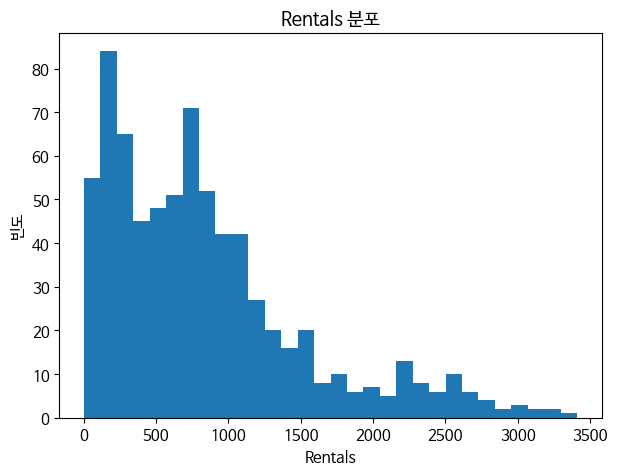

In [ ]:

# 4-1) 타깃(Rentals) 분포
plt.figure()
plt.hist(df['Rentals'], bins=30)
plt.title('Rentals 분포')
plt.xlabel('Rentals')
plt.ylabel('빈도')
plt.show()


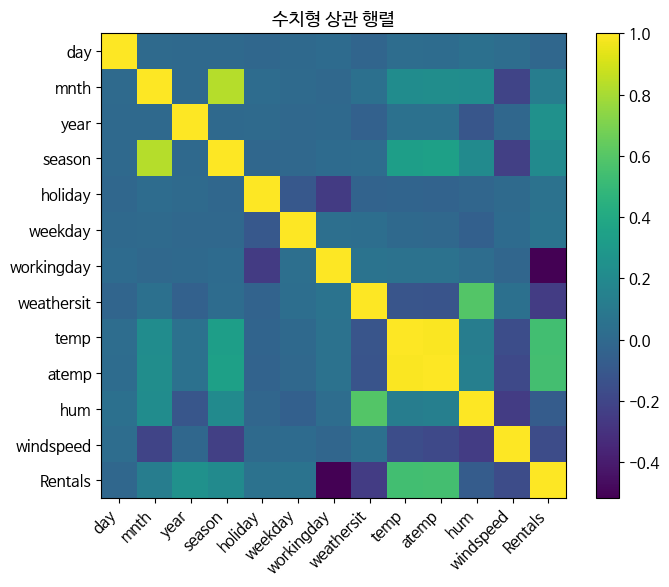

In [ ]:

# 4-2) 피처 간 상관 행렬 (matplotlib만 사용)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
im = plt.imshow(corr, interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.title('수치형 상관 행렬')
plt.tight_layout()
plt.show()


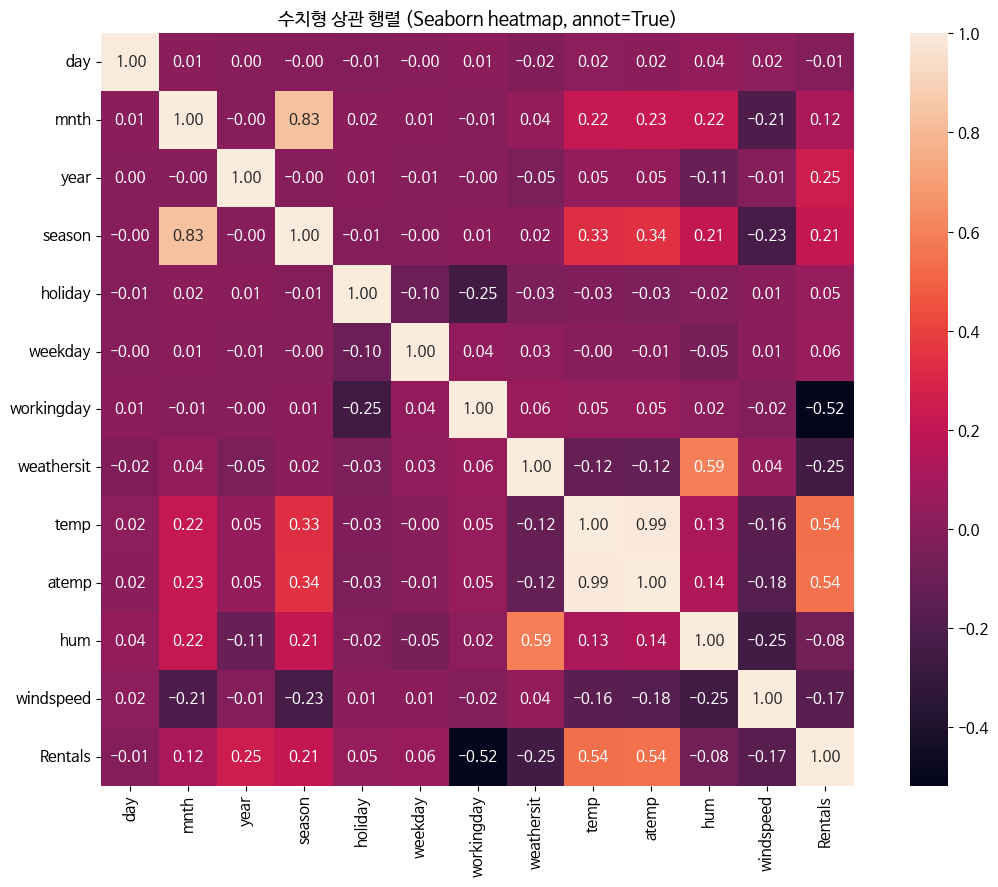

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 컬럼만 선택해 상관계수 계산
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

# 히트맵 (상관계수 수치 표기 + 큰 사이즈)
plt.figure(figsize=(12, 9))
sns.heatmap(
    corr,
    annot=True,        # 수치 표기
    fmt=".2f",         # 소수 둘째 자리
    square=True,
    cbar=True,
    xticklabels=num_cols,
    yticklabels=num_cols
)
plt.title('수치형 상관 행렬 (Seaborn heatmap, annot=True)')
plt.tight_layout()
plt.show()


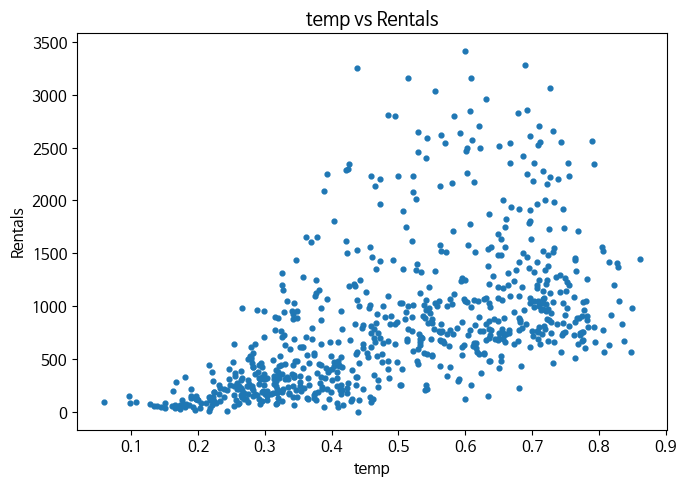

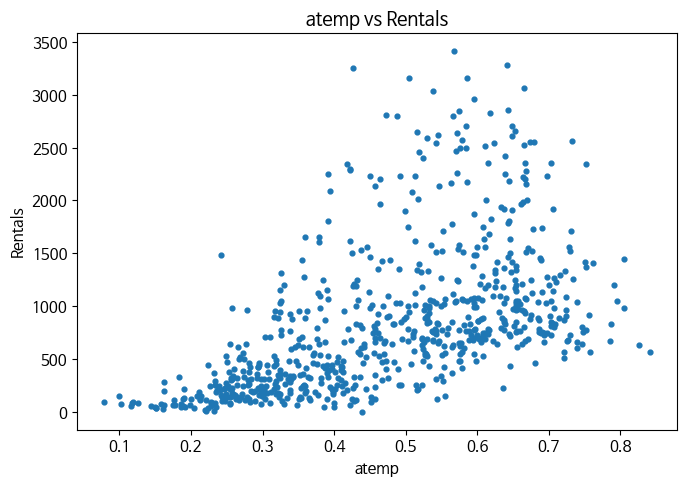

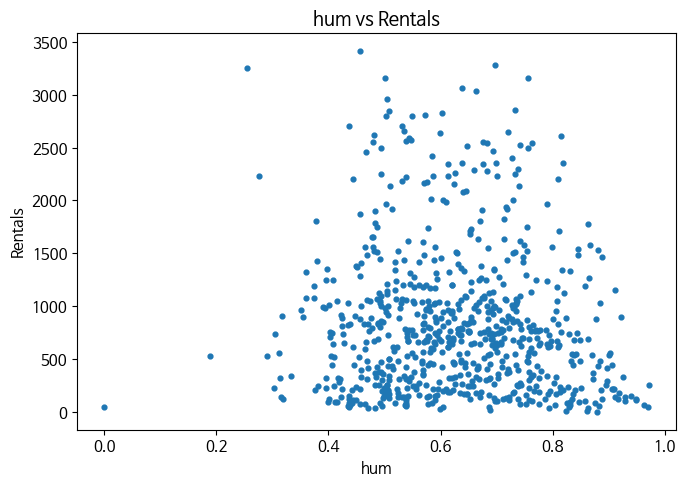

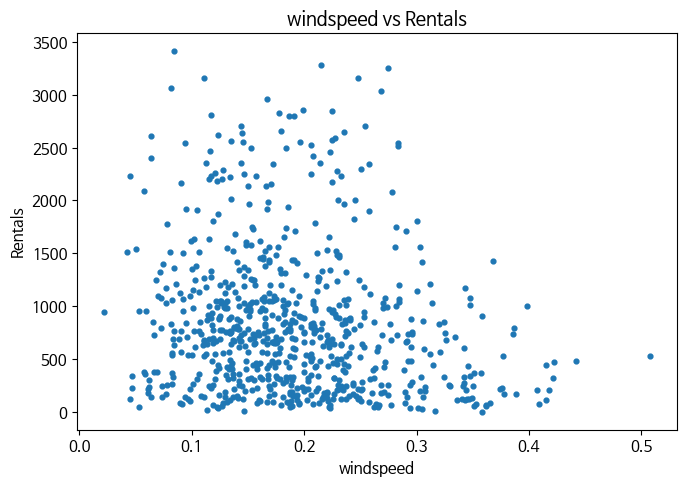

In [ ]:

# 4-3) 주요 연속형 변수 vs Rentals 산포도
cont_features = ['temp', 'atemp', 'hum', 'windspeed']
for col in cont_features:
    if col in df.columns:
        plt.figure()
        plt.scatter(df[col], df['Rentals'], s=12)
        plt.title(f'{col} vs Rentals')
        plt.xlabel(col)
        plt.ylabel('Rentals')
        plt.tight_layout()
        plt.show()


## 5) 전처리 & 학습/평가 (year/day 제외)

In [ ]:
# 타깃/피처 분리
TARGET = 'Rentals'
drop_cols = ['year', 'day']  # 명시된 배제 컬럼
X = df.drop(columns=[TARGET] + [c for c in drop_cols if c in df.columns])
y = df[TARGET]

# 수치/범주형 구분
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# bike 데이터는 정수형이지만 'season', 'weekday', 'weathersit', 'holiday', 'workingday' 등
# **범주형 의미**를 갖는 컬럼이 존재합니다. 아래에서 사람이 해석 가능한 범주형 후보를 지정합니다.
candidate_cats = ['season','holiday','weekday','workingday','weathersit','mnth']
for cc in candidate_cats:
    if cc in num_features:
        num_features.remove(cc)
        cat_features.append(cc)

print('수치형:', num_features)
print('범주형:', cat_features)

# 전처리기: 범주형 원-핫, 수치형 표준화
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='drop'
)

# 모델 파이프라인
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('reg', LinearRegression())
])

# 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 학습
model.fit(X_train, y_train)

# 예측
pred_train = model.predict(X_train)
pred_test  = model.predict(X_test)

# 성능지표
def metrics(y_true, y_pred, label=''):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'[{label}] MAE={mae:.3f} | RMSE={rmse:.3f} | R^2={r2:.3f}')

metrics(y_train, pred_train, 'train')
metrics(y_test,  pred_test,  'test')

수치형: ['temp', 'atemp', 'hum', 'windspeed']
범주형: ['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'mnth']
[train] MAE=280.029 | RMSE=375.965 | R^2=0.711
[test] MAE=292.565 | RMSE=373.680 | R^2=0.642


## 6) 예측 진단

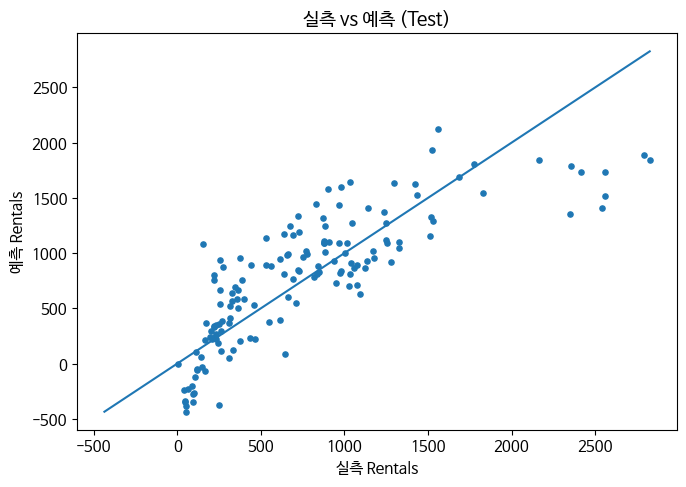

In [ ]:

# 실측 vs 예측 (test)
plt.figure()
plt.scatter(y_test, pred_test, s=14)
lim_min = min(y_test.min(), pred_test.min())
lim_max = max(y_test.max(), pred_test.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max])
plt.title('실측 vs 예측 (Test)')
plt.xlabel('실측 Rentals')
plt.ylabel('예측 Rentals')
plt.tight_layout()
plt.show()
